# Main Code

In [3]:
# Installing packages
#!pip install pandas openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)


In [39]:
# Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os

## Loading data files

In [2]:
# Loading data
data = pd.read_excel("Data/Data_final.xlsx") 

# Display the first 5 rows
print(data.head())

metadata = pd.read_excel("Data/Metadata_final.xlsx") 

# Display the first 5 rows  
print(metadata.head())

         Sample_Name  SeaDistance_m Location Duplicate    Datetime   Latitude  \
0  SLWT_2024_01_19_A            NaN    shore         A  2024_01_19  16.625000   
1  SLWT_2024_01_19_B            NaN    shore         B  2024_01_19  16.625000   
2  SLWT_2024_01_20_A            NaN    shore         A  2024_01_20  16.401667   
3  SLWT_2024_01_20_B            NaN    shore         B  2024_01_20  16.401667   
4  SLWT_2024_01_21_A            NaN    shore         A  2024_01_21  16.316667   

   Longitude  Type  HP_12CH4_dry_mean  HR_12CH4_dry_mean  ...  AirT_degC  \
0 -25.325000   NaN           1.854859           1.838359  ...       24.5   
1 -25.325000   NaN           1.729128           1.715480  ...       24.5   
2 -27.518333   NaN           1.827733           1.818951  ...       23.5   
3 -27.518333   NaN           1.892697           1.893364  ...       23.5   
4 -30.581667   NaN           1.902200           1.882740  ...       25.0   

   AirP_hPa  CH4atm_ppm  CO2atm_ppm  d13C_CH4atm_permil 

In [3]:
#change of units for CH4: mmol/m3 --> umol/m3
data['ch4_umolm3'] = data['ch4_mmolm3'] * 10**3 
print(data.head())

         Sample_Name  SeaDistance_m Location Duplicate    Datetime   Latitude  \
0  SLWT_2024_01_19_A            NaN    shore         A  2024_01_19  16.625000   
1  SLWT_2024_01_19_B            NaN    shore         B  2024_01_19  16.625000   
2  SLWT_2024_01_20_A            NaN    shore         A  2024_01_20  16.401667   
3  SLWT_2024_01_20_B            NaN    shore         B  2024_01_20  16.401667   
4  SLWT_2024_01_21_A            NaN    shore         A  2024_01_21  16.316667   

   Longitude  Type  HP_12CH4_dry_mean  HR_12CH4_dry_mean  ...  AirP_hPa  \
0 -25.325000   NaN           1.854859           1.838359  ...    1016.0   
1 -25.325000   NaN           1.729128           1.715480  ...    1016.0   
2 -27.518333   NaN           1.827733           1.818951  ...    1014.7   
3 -27.518333   NaN           1.892697           1.893364  ...    1014.7   
4 -30.581667   NaN           1.902200           1.882740  ...    1014.9   

   CH4atm_ppm  CO2atm_ppm  d13C_CH4atm_permil  d13C_CO2atm_per

## Loading Variables

In [4]:
# Some usefull variables

R_JKmol = 8.314 # [J/K/mol], ideal gas law
V_w_L = 0.105 #[L], volume of the water sample in the syringe
V_hs_L = 0.35 #[L], volume of the headspace in the syringe
V_tot_L = 0.140 #[L], volume total of the syringe
P_atm_Pa = 101325 #[Pa], atmospheric pressure

## Calculation of ocean-air fluxes for CO2 and methane

### Partial pressure - Pi [Pa]

In [5]:
# CO2
Pi_CO2_Pa = data["CO2atm_ppm"] * 10**(-6) * P_atm_Pa
#print(Pi_CO2_Pa)

#CH4
Pi_CH4_Pa = data["CH4atm_ppm"] * 10**(-6) * P_atm_Pa
#print(Pi_CH4_Pa)

### Gas concentration in the water - n [mol]

In [6]:
#convert Temp at equilibrium (assumed to be the Temp after shaking) in Kelvin
Te_K = data["Te_degC"] + 273.15 
#print(Te_K)

In [7]:
# Ideal Gas Law (Magen et al., 2014) 
#converting V_w_L in m3
V_w_m3 = V_w_L / 1000

n_CO2_mol = Pi_CO2_Pa * V_w_m3 / (R_JKmol * Te_K)
#print(n_CO2_mol)

n_CH4_mol = Pi_CH4_Pa * V_w_m3 / (R_JKmol * Te_K)
#print(n_CH4_mol)

### Corrected Henry's coefficients [mol/m3/Pa]

In [8]:
# CO2 (Weiss 1974)
A = [-58.0931, 90.5069, 22.2940]
B = [0.027766, -0.025888, 0.0050578]
hcpsalt_CO2_molm3Pa = (
    np.exp(
    A[0]
    + A[1] * 100 / Te_K
    + A[2] * np.log(Te_K / 100)
    + data["sal_psu"] * (B[0] + B[1] * Te_K / 100 + B[2] * (Te_K / 100) ** 2)
    ) * 1000/ 101325 
    )
#print(hcpsalt_CO2_molm3Pa)

In [9]:
# CH4 (Wiesenburg and Guinasso 1979)
A = [-417.5053, 599.8626, 380.3636, -62.0764]
B = [-0.064236, 0.03498, -0.0052732]
c_molm3 = (
    np.exp(
    + A[0]
    + A[1] * 100 / Te_K
    + A[2] * np.log(Te_K / 100)
    + A[3] * (Te_K / 100)
    + data["sal_psu"] * (B[0] + B[1] * Te_K / 100 + B[2] * (Te_K / 100) ** 2)
    ) * 1000 / 1e9
    )

hcpsalt_CH4_molm3Pa = c_molm3 / 101325

#print(hcpsalt__CH4_molm3Pa)

### Dissolved water concentration [mol/m3] or solubility of the gases

In [10]:
# Henry’s Law (Sander, 2023)
# CO2
C_eq_CO2_molm3 = hcpsalt_CO2_molm3Pa * Pi_CO2_Pa
#print(C_eq_CO2_molm3)

# CH4
C_eq_CH4_molm3 = hcpsalt_CH4_molm3Pa * Pi_CH4_Pa
#print(C_eq_CH4_molm3)

### Gas transfer velocity K600 [m/d]

In [11]:
# Function to extract min and max wind speed
kts_to_ms = 1852 / 3600

def WS_min_max(wind_speed):
    if isinstance(wind_speed, str) and '-' in wind_speed:  # Check if it's a range
        min_val, max_val = map(float, wind_speed.split('-'))  # Split and convert to float
    else:
        min_val = max_val = float(wind_speed)  # If it's a single number
    return pd.Series([min_val, max_val])

# Apply function to create new columns
metadata[['Min_Wind_Speed [kts]', 'Max_Wind_Speed [kts]']] = metadata['TWS [kts]'].apply(WS_min_max)

# Convert knots to meters per second
metadata['Min_Wind_Speed [m/s]'] = metadata['Min_Wind_Speed [kts]'] * kts_to_ms
metadata['Max_Wind_Speed [m/s]'] = metadata['Max_Wind_Speed [kts]'] * kts_to_ms

# Display the first rows
print(metadata.head())

         Sample_Name   Latitude  Longitude TWS [kts]  SOG [kts]  P_atm [hPa]  \
0  SLWT_2024_01_19_A  16.625000 -25.325000         7        4.5       1016.0   
1  SLWT_2024_01_19_B  16.625000 -25.325000         7        4.5       1016.0   
2  SLWT_2024_01_20_A  16.401667 -27.518333        16        7.6       1014.7   
3  SLWT_2024_01_20_B  16.401667 -27.518333        16        7.6       1014.7   
4  SLWT_2024_01_21_A  16.316667 -30.581667        19        7.5       1014.9   

   T_air [°C]   pH  Tw_b [°C]  Tw_a [°C] Mer [Douglas]  \
0        24.5  7.5       24.0       23.5             3   
1        24.5  7.5       23.5       23.5             3   
2        23.5  7.5       24.8       25.4           3-4   
3        23.5  7.5       24.5       25.2           3-4   
4        25.0  7.5       24.7       25.3             3   

                           Remarks  Min_Wind_Speed [kts]  \
0  Air pressure from NOAA archives                   7.0   
1  Air pressure from NOAA archives                

In [12]:
# Calculation of the gas transfer velocity K600 (MacIntyre et al., 2010) 
K600_min_md = (2.04 * metadata["Min_Wind_Speed [m/s]"] + 2.0) * 0.24 # conversion from cm/h to m/d
print(K600_min_md)

K600_max_md = (2.04 * metadata["Max_Wind_Speed [m/s]"] + 2.0) * 0.24 # conversion from cm/h to m/d
#print(K600_max_md)

0     2.243104
1     2.243104
2     4.509952
3     4.509952
4     5.265568
5     5.265568
6     3.603213
7     3.603213
8     4.006208
9     4.006208
10    3.250592
11    3.754336
12    3.754336
13    3.250592
14    3.250592
15    4.006208
16    4.006208
17    4.761824
18    4.761824
19    4.258080
20    4.258080
21    4.258080
22    3.502464
23    3.250592
24    3.250592
25    3.250592
26    3.250592
27    3.250592
28    2.494976
29    2.494976
30    1.739360
31    1.739360
32    1.739360
33    1.739360
34    8.036160
35    8.036160
36    4.258080
37    4.258080
38    2.494976
39    2.494976
40    0.983744
41    3.502464
42    3.502464
43    0.983744
44    0.983744
45    4.258080
46    1.739360
47    1.739360
48    0.983744
49    0.731872
50    0.731872
Name: Min_Wind_Speed [m/s], dtype: float64


### Schmidt number - Sc [-]

In [13]:
# (Wanninkhof, 2014) - temperature of the water in °C
#CO2
Sc_CO2 =  2073.1 - 125.62 * metadata["Tw_b [°C]"] + 3.6276 * metadata["Tw_b [°C]"]**2 - 0.043219 * metadata["Tw_b [°C]"]**3
#print(Sc_CO2)

#CH4
Sc_CH4 = 2039.2 - 120.31 * metadata["Tw_b [°C]"] + 3.4209 * metadata["Tw_b [°C]"]**2 - 0.040437 * metadata["Tw_b [°C]"]**3
#print(Sc_CH4)

### Exchange coefficient - Ki [m/d]

In [14]:
# Define n from the gas exchange equation (n = 0.5 for wind speeds > 3.7 [m s-1] or, n = 0.66 for wind speeds < 3.7 [m s-1]) :
def WS_n (wind_speed) :
    if wind_speed < 3.7 :
        n = 0.66
    else:
        n = 0.5
    return n

metadata['Min_n'] = metadata['Min_Wind_Speed [m/s]'].apply(WS_n)
metadata['Max_n'] = metadata['Max_Wind_Speed [m/s]'].apply(WS_n)

print(metadata.head())

         Sample_Name   Latitude  Longitude TWS [kts]  SOG [kts]  P_atm [hPa]  \
0  SLWT_2024_01_19_A  16.625000 -25.325000         7        4.5       1016.0   
1  SLWT_2024_01_19_B  16.625000 -25.325000         7        4.5       1016.0   
2  SLWT_2024_01_20_A  16.401667 -27.518333        16        7.6       1014.7   
3  SLWT_2024_01_20_B  16.401667 -27.518333        16        7.6       1014.7   
4  SLWT_2024_01_21_A  16.316667 -30.581667        19        7.5       1014.9   

   T_air [°C]   pH  Tw_b [°C]  Tw_a [°C] Mer [Douglas]  \
0        24.5  7.5       24.0       23.5             3   
1        24.5  7.5       23.5       23.5             3   
2        23.5  7.5       24.8       25.4           3-4   
3        23.5  7.5       24.5       25.2           3-4   
4        25.0  7.5       24.7       25.3             3   

                           Remarks  Min_Wind_Speed [kts]  \
0  Air pressure from NOAA archives                   7.0   
1  Air pressure from NOAA archives                

In [15]:
# Find indices where Min and Max n are different
indices = metadata[metadata["Min_n"] != metadata["Max_n"]].index
print(indices)

Index([30, 31], dtype='int64')


In [16]:
# Gas exchange for CO2 (McGinnis et al., 2015) 
Ki_min_CO2_md = K600_min_md * (600 / Sc_CO2)**(-metadata["Min_n"])
#print(Ki_min_CO2_md)

Ki_max_CO2_md = K600_max_md * (600 / Sc_CO2)**(-metadata["Max_n"])
#print(Ki_max_CO2_md)

In [17]:
# Gas exchange for CH4 (McGinnis et al., 2015) 
Ki_min_CH4_md = K600_min_md * (600 / Sc_CH4)**(-metadata["Min_n"])
#print(Ki_min_CH4_md)

Ki_max_CH4_md = K600_max_md * (600 / Sc_CH4)**(-metadata["Max_n"])
#print(Ki_max_CH4_md)

### Ocean-air fluxes - F [mmol/m2/d] 

In [18]:
#Fick’s first law for CO2 (Fick, 1855) 
F_min_CO2_mmolm2d = Ki_min_CO2_md * (data["co2_mmolm3"] - C_eq_CO2_molm3 * 10**3)
F_max_CO2_mmolm2d = Ki_max_CO2_md * (data["co2_mmolm3"] - C_eq_CO2_molm3 * 10**3)
F_mean_CO2_mmolm2d = np.mean([F_min_CO2_mmolm2d, F_max_CO2_mmolm2d], axis = 0)

df = pd.DataFrame({'Min CO2 flux': F_min_CO2_mmolm2d, 'Max CO2 flux': F_max_CO2_mmolm2d, 'Mean CO2 flux' : F_mean_CO2_mmolm2d })
display(df)

,Min CO2 flux,Max CO2 flux,Mean CO2 flux
0,8.184870,8.184870,8.184870
1,15.599036,15.599036,15.599036
2,15.219398,15.219398,15.219398
3,15.805153,15.805153,15.805153
4,1.376227,1.376227,1.376227
5,3.745745,3.745745,3.745745
6,6.687741,6.687741,6.687741
7,5.564639,5.564639,5.564639
8,4.166852,4.166852,4.166852
9,1.735661,1.735661,1.735661


In [19]:
#Fick’s first law for CH4 (Fick, 1855)
F_min_CH4_umolm2d = Ki_min_CH4_md * (data["ch4_mmolm3"] - C_eq_CH4_molm3 * 10**(3)) * 10**3
F_max_CH4_umolm2d = Ki_max_CH4_md * (data["ch4_mmolm3"] - C_eq_CH4_molm3 * 10**(3)) * 10**3
F_mean_CH4_umolm2d = np.mean([F_min_CH4_umolm2d, F_max_CH4_umolm2d], axis = 0)

df = pd.DataFrame({'Min CH4 flux': F_min_CH4_umolm2d, 'Max CH4 flux': F_max_CH4_umolm2d, 'Mean CH4 flux' : F_mean_CH4_umolm2d})
display(df)

,Min CH4 flux,Max CH4 flux,Mean CH4 flux
0,2.327666,2.327666,2.327666
1,-1.810165,-1.810165,-1.810165
2,10.796398,10.796398,10.796398
3,15.182311,15.182311,15.182311
4,5.818389,5.818389,5.818389
5,5.871222,5.871222,5.871222
6,1.051704,1.051704,1.051704
7,2.324586,2.324586,2.324586
8,1.488210,1.488210,1.488210
9,-2.296694,-2.296694,-2.296694


### Creating dataframe with all the results

In [34]:
# Creating a big datafrane with all the results
# for CO2
df_CO2 = pd.DataFrame({'Datetime' : data["Datetime"], 'Lat' : data["Latitude"], 'Long' : data["Longitude"],  'Pi CO2 [Pa]' : Pi_CO2_Pa, 'n CO2 [mol]' : n_CO2_mol, 'Henrys coeff [molm3Pa] ' : hcpsalt_CO2_molm3Pa, 
                   'C_eq CO2 [molm3]' : C_eq_CO2_molm3, 'Min K600 [m/d]' : K600_min_md, 'Max K600 [m/d]' : K600_max_md,
                   'Sc CO2 [-]' : Sc_CO2, 'Min Ki CO2 [m/d]' : Ki_min_CO2_md, 'Max Ki CO2 [m/d]' : Ki_max_CO2_md,  
                   'Min CO2 flux [mmol/m2/d]': F_min_CO2_mmolm2d, 'Max CO2 flux [mmol/m2/d]': F_max_CO2_mmolm2d, 'Mean CO2 flux [mmol/m2/d]' : F_mean_CO2_mmolm2d})
display(df_CO2)

,Datetime,Lat,Long,Pi CO2 [Pa],n CO2 [mol],Henrys coeff [molm3Pa],C_eq CO2 [molm3],Min K600 [m/d],Max K600 [m/d],Sc CO2 [-],Min Ki CO2 [m/d],Max Ki CO2 [m/d],Min CO2 flux [mmol/m2/d],Max CO2 flux [mmol/m2/d],Mean CO2 flux [mmol/m2/d]
0,2024_01_19,16.625000,-25.325000,43.958510,0.000002,0.000296,0.013029,2.243104,2.243104,550.258144,2.118573,2.118573,8.184870,8.184870,8.184870
1,2024_01_19,16.625000,-25.325000,43.958510,0.000002,0.000296,0.013029,2.243104,2.243104,563.481320,2.152039,2.152039,15.599036,15.599036,15.599036
2,2024_01_20,16.401667,-27.518333,38.189018,0.000002,0.000282,0.010776,4.509952,4.509952,529.624043,4.237211,4.237211,15.219398,15.219398,15.219398
3,2024_01_20,16.401667,-27.518333,38.189018,0.000002,0.000284,0.010831,4.509952,4.509952,537.292884,4.267778,4.267778,15.805153,15.805153,15.805153
4,2024_01_21,16.316667,-30.581667,45.106187,0.000002,0.000283,0.012757,5.265568,5.265568,532.171735,4.959016,4.959016,1.376227,1.376227,1.376227
5,2024_01_21,16.316667,-30.581667,45.106187,0.000002,0.000287,0.012954,5.265568,5.265568,537.292884,4.982819,4.982819,3.745745,3.745745,3.745745
6,2024_01_22,16.036667,-33.103333,43.956948,0.000002,0.000256,0.011249,3.603213,3.603213,499.620456,3.288020,3.288020,6.687741,6.687741,6.687741
7,2024_01_22,16.036667,-33.103333,43.956948,0.000002,0.000265,0.011630,3.603213,3.603213,499.620456,3.288020,3.288020,5.564639,5.564639,5.564639
8,2024_01_23,15.370000,-35.616667,44.130671,0.000002,0.000266,0.011735,4.006208,4.006208,489.805560,3.619676,3.619676,4.166852,4.166852,4.166852
9,2024_01_23,15.370000,-35.616667,44.130671,0.000002,0.000265,0.011679,4.006208,4.006208,487.362717,3.610639,3.610639,1.735661,1.735661,1.735661


In [21]:
# for CH4
df_CH4 = pd.DataFrame({'Datetime' : data["Datetime"], 'Lat' : data["Latitude"], 'Long' : data["Longitude"], 'Pi CH4 [Pa]' : Pi_CH4_Pa, 'n CH4 [mol]' : n_CH4_mol, 'Henrys coeff CH4 [molm3Pa] ' : hcpsalt_CH4_molm3Pa, 
                   'C_eq CH4 [molm3]' : C_eq_CH4_molm3, 'Min K600 [m/d]' : K600_min_md, 'Max K600 [m/d]' : K600_max_md,
                   'Sc CH4 [-]' : Sc_CH4, 'Min Ki CH4 [m/d]' : Ki_min_CH4_md, 'Max Ki CH4 [m/d]' : Ki_max_CH4_md,  
                   'Min CH4 flux [umol/m2/d]': F_min_CH4_umolm2d, 'Max CH4 flux [umol/m2/d]': F_max_CH4_umolm2d, 'Mean CH4 flux [umol/m2/d]' : F_mean_CH4_umolm2d})
display(df_CH4)

,Datetime,Lat,Long,Pi CH4 [Pa],n CH4 [mol],Henrys coeff CH4 [molm3Pa],C_eq CH4 [molm3],Min K600 [m/d],Max K600 [m/d],Sc CH4 [-],Min Ki CH4 [m/d],Max Ki CH4 [m/d],Min CH4 flux [umol/m2/d],Max CH4 flux [umol/m2/d],Mean CH4 flux [umol/m2/d]
0,2024_01_19,16.625000,-25.325000,0.185789,7.909599e-09,0.000011,0.000002,2.243104,2.243104,563.197312,2.151323,2.151323,2.327666,2.327666,2.327666
1,2024_01_19,16.625000,-25.325000,0.185789,7.909599e-09,0.000011,0.000002,2.243104,2.243104,576.320694,2.184278,2.184278,-1.810165,-1.810165,-1.810165
2,2024_01_20,16.401667,-27.518333,0.171231,7.243424e-09,0.000010,0.000002,4.509952,4.509952,542.717098,4.289267,4.289267,10.796398,10.796398,10.796398
3,2024_01_20,16.401667,-27.518333,0.171231,7.248280e-09,0.000010,0.000002,4.509952,4.509952,550.328648,4.319240,4.319240,15.182311,15.182311,15.182311
4,2024_01_21,16.316667,-30.581667,0.189187,8.005712e-09,0.000010,0.000002,5.265568,5.265568,545.245711,5.019561,5.019561,5.818389,5.818389,5.818389
5,2024_01_21,16.316667,-30.581667,0.189187,8.021839e-09,0.000011,0.000002,5.265568,5.265568,550.328648,5.042904,5.042904,5.871222,5.871222,5.871222
6,2024_01_22,16.036667,-33.103333,0.189799,7.922750e-09,0.000010,0.000002,3.603213,3.603213,512.947688,3.331584,3.331584,1.051704,1.051704,1.051704
7,2024_01_22,16.036667,-33.103333,0.189799,7.959581e-09,0.000010,0.000002,3.603213,3.603213,512.947688,3.331584,3.331584,2.324586,2.324586,2.324586
8,2024_01_23,15.370000,-35.616667,0.190664,8.001154e-09,0.000010,0.000002,4.006208,4.006208,503.216016,3.668893,3.668893,1.488210,1.488210,1.488210
9,2024_01_23,15.370000,-35.616667,0.190664,7.995840e-09,0.000010,0.000002,4.006208,4.006208,500.794619,3.660056,3.660056,-2.296694,-2.296694,-2.296694


## Calculation of some mean values

### Fluxes

In [22]:
#CO2
#overrall mean values
mean_F_min_CO2_mmolm2d = np.mean(F_min_CO2_mmolm2d)
mean_F_max_CO2_mmolm2d = np.mean(F_max_CO2_mmolm2d)
mean_F_mean_CO2_mmolm2d = np.mean(F_mean_CO2_mmolm2d)
print("Mean min CO2 flux:", mean_F_min_CO2_mmolm2d.round(2), "mmol/m2/d")
print("Mean max CO2 flux:", mean_F_max_CO2_mmolm2d.round(2), "mmol/m2/d")
print("Mean mean CO2 flux:", mean_F_mean_CO2_mmolm2d.round(2), "mmol/m2/d", "\n")

#mean value of transatlantic samples
mean_min_F_CO2_transat = np.mean(F_min_CO2_mmolm2d[0:28])
mean_max_F_CO2_transat = np.mean(F_max_CO2_mmolm2d[0:28])
mean_mean_F_CO2_transat = np.mean(F_mean_CO2_mmolm2d[0:28])
print("Transatlantic mean min CO2 flux:", mean_min_F_CO2_transat.round(2), "mmol/m2/d")
print("Transatlantic mean max CO2 flux:", mean_max_F_CO2_transat.round(2), "mmol/m2/d")
print("Transatlantic mean mean CO2 flux:", mean_mean_F_CO2_transat.round(2), "mmol/m2/d", "\n")

#mean value of Labrador sea samples
mean_min_F_CO2_labrador = np.mean(F_min_CO2_mmolm2d[28:38])
mean_max_F_CO2_labrador = np.mean(F_max_CO2_mmolm2d[28:38])
mean_mean_F_CO2_labrador = np.mean(F_mean_CO2_mmolm2d[28:38])
print("Labrador sea mean min CO2 flux:", mean_min_F_CO2_labrador.round(2), "mmol/m2/d")
print("Labrador sea mean max CO2 flux:", mean_max_F_CO2_labrador.round(2), "mmol/m2/d")
print("Labrador sea mean mean CO2 flux:", mean_mean_F_CO2_labrador.round(2), "mmol/m2/d", "\n")

#mean value of Greeanland samples
mean_min_F_CO2_greenland = np.mean(F_min_CO2_mmolm2d[38:])
mean_max_F_CO2_greenland = np.mean(F_max_CO2_mmolm2d[38:])
mean_mean_F_CO2_greenland = np.mean(F_mean_CO2_mmolm2d[38:])
print("Greenland mean min CO2 flux:", mean_min_F_CO2_greenland.round(2), "mmol/m2/d")
print("Greenland mean max CO2 flux:", mean_max_F_CO2_greenland.round(2), "mmol/m2/d")
print("Greenland mean mean CO2 flux:", mean_mean_F_CO2_greenland.round(2), "mmol/m2/d")

Mean min CO2 flux: -3.23 mmol/m2/d
Mean max CO2 flux: -3.52 mmol/m2/d
Mean mean CO2 flux: -3.37 mmol/m2/d 

Transatlantic mean min CO2 flux: 5.03 mmol/m2/d
Transatlantic mean max CO2 flux: 5.33 mmol/m2/d
Transatlantic mean mean CO2 flux: 5.18 mmol/m2/d 

Labrador sea mean min CO2 flux: -23.35 mmol/m2/d
Labrador sea mean max CO2 flux: -25.7 mmol/m2/d
Labrador sea mean mean CO2 flux: -24.52 mmol/m2/d 

Greenland mean min CO2 flux: -5.53 mmol/m2/d
Greenland mean max CO2 flux: -5.52 mmol/m2/d
Greenland mean mean CO2 flux: -5.53 mmol/m2/d


In [23]:
#CH4
#overall mean values
mean_F_min_CH4_umolm2d = np.mean(F_min_CH4_umolm2d)
mean_F_max_CH4_umolm2d = np.mean(F_max_CH4_umolm2d)
mean_F_mean_CH4_umolm2d = np.mean(F_mean_CH4_umolm2d)
print("Mean min CH4 flux:", mean_F_min_CH4_umolm2d.round(2), "umol/m2/d")
print("Mean max CH4 flux:", mean_F_max_CH4_umolm2d.round(2), "umol/m2/d")
print("Mean mean CH4 flux:", mean_F_mean_CH4_umolm2d.round(2), "umol/m2/d", "\n")

#mean value of transatlantic samples
mean_min_F_CH4_transat = np.mean(F_min_CH4_umolm2d[0:28])
mean_max_F_CH4_transat = np.mean(F_max_CH4_umolm2d[0:28])
mean_mean_F_CH4_transat = np.mean(F_mean_CH4_umolm2d[0:28])
print("Transatlantic mean min CH4 flux:", mean_min_F_CH4_transat.round(2), "umol/m2/d")
print("Transatlantic mean max CH4 flux:", mean_max_F_CH4_transat.round(2),"umol/m2/d")
print("Transatlantic mean mean CH4 flux:", mean_mean_F_CH4_transat.round(2),"umol/m2/d",  "\n")

#mean value of Labrador sea samples
mean_min_F_CH4_labrador = np.mean(F_min_CH4_umolm2d[28:38])
mean_max_F_CH4_labrador = np.mean(F_max_CH4_umolm2d[28:38])
mean_mean_F_CH4_labrador = np.mean(F_mean_CH4_umolm2d[28:38])
print("Labrador sea mean min CH4 flux:", mean_min_F_CH4_labrador.round(2), "umol/m2/d")
print("Labrador sea mean max CH4 flux:", mean_max_F_CH4_labrador.round(2), "umol/m2/d")
print("Labrador sea mean mean CH4 flux:", mean_mean_F_CH4_labrador.round(2), "umol/m2/d", "\n")

#mean value of Greeanland samples
mean_min_F_CH4_greenland = np.mean(F_min_CH4_umolm2d[38:])
mean_max_F_CH4_greenland = np.mean(F_max_CH4_umolm2d[38:])
mean_mean_F_CH4_greenland = np.mean(F_mean_CH4_umolm2d[38:])
print("Greenland mean min CH4 flux:", mean_min_F_CH4_greenland.round(2), "umol/m2/d")
print("Greenland mean max CH4 flux:", mean_max_F_CH4_greenland.round(2), "umol/m2/d")
print("Greenland mean mean CH4 flux:", mean_mean_F_CH4_greenland.round(2), "umol/m2/d")

Mean min CH4 flux: 5.23 umol/m2/d
Mean max CH4 flux: 5.94 umol/m2/d
Mean mean CH4 flux: 5.58 umol/m2/d 

Transatlantic mean min CH4 flux: 4.56 umol/m2/d
Transatlantic mean max CH4 flux: 4.78 umol/m2/d
Transatlantic mean mean CH4 flux: 4.67 umol/m2/d 

Labrador sea mean min CH4 flux: 8.14 umol/m2/d
Labrador sea mean max CH4 flux: 11.08 umol/m2/d
Labrador sea mean mean CH4 flux: 9.61 umol/m2/d 

Greenland mean min CH4 flux: 4.43 umol/m2/d
Greenland mean max CH4 flux: 4.47 umol/m2/d
Greenland mean mean CH4 flux: 4.45 umol/m2/d


### Dissolved (water) concentration

In [24]:
#CO2
#overrall mean values
mean_co2_mmolm3 = np.mean(data['co2_mmolm3'])
print("Mean dissolved CO2:", mean_co2_mmolm3.round(2), "mmol/m3", "\n")

#mean value of transatlantic samples
mean_co2_mmolm3_transat = np.mean(data['co2_mmolm3'][0:28])
print("Transatlantic mean dissolved CO2:", mean_co2_mmolm3_transat.round(2), "mmol/m3", "\n")

#mean value of Labrador sea samples
mean_co2_mmolm3_labrador = np.mean(data['co2_mmolm3'][28:38])
print("Labrador sea mean dissolved CO2:", mean_co2_mmolm3_labrador.round(2), "mmol/m3", "\n")

#mean value of Greeanland samples
mean_co2_mmolm3_greenland = np.mean(data['co2_mmolm3'][38:])
print("Greenland mean dissolved CO2:", mean_co2_mmolm3_greenland.round(2), "mmol/m3",)

Mean dissolved CO2: 15.88 mmol/m3 

Transatlantic mean dissolved CO2: 13.49 mmol/m3 

Labrador sea mean dissolved CO2: 17.61 mmol/m3 

Greenland mean dissolved CO2: 19.69 mmol/m3


In [25]:
#CH4
#overrall mean values
mean_ch4_umolm3 = np.mean(data['ch4_umolm3'])
print("Mean dissolved CH4:", mean_ch4_umolm3.round(2), "umol/m3", "\n")

#mean value of transatlantic samples
mean_ch4_umolm3_transat = np.mean(data['ch4_umolm3'][0:28])
print("Transatlantic mean dissolved CH4:", mean_ch4_umolm3_transat.round(2), "umol/m3", "\n")

#mean value of Labrador sea samples
mean_ch4_umolm3_labrador = np.mean(data['ch4_umolm3'][28:38])
print("Labrador sea mean dissolved CH4:", mean_ch4_umolm3_labrador.round(2), "umol/m3", "\n")

#mean value of Greeanland samples
mean_ch4_umolm3_greenland = np.mean(data['ch4_umolm3'][38:])
print("Greenland mean dissolved CH4:", mean_ch4_umolm3_greenland.round(2), "umol/m3",)

Mean dissolved CH4: 3.92 umol/m3 

Transatlantic mean dissolved CH4: 3.09 umol/m3 

Labrador sea mean dissolved CH4: 5.24 umol/m3 

Greenland mean dissolved CH4: 4.69 umol/m3


### Atmopheric concentration

In [26]:
#CO2
#overrall mean values
mean_CO2atm_ppm = np.mean(data['CO2atm_ppm'])
print("Mean dissolved CO2:", mean_CO2atm_ppm.round(2), "ppm", "\n")

#mean value of transatlantic samples
mean_CO2atm_ppm_transat = np.mean(data['CO2atm_ppm'][0:28])
print("Transatlantic mean dissolved CO2:", mean_CO2atm_ppm_transat.round(2), "ppm", "\n")

#mean value of Labrador sea samples
mean_CO2atm_ppm_labrador = np.mean(data['CO2atm_ppm'][28:38])
print("Labrador sea mean dissolved CO2:", mean_CO2atm_ppm_labrador.round(2), "ppm", "\n")

#mean value of Greeanland samples
mean_CO2atm_ppm_greenland = np.mean(data['CO2atm_ppm'][38:])
print("Greenland mean dissolved CO2:", mean_CO2atm_ppm_greenland.round(2), "ppm",)

Mean dissolved CO2: 430.55 ppm 

Transatlantic mean dissolved CO2: 434.81 ppm 

Labrador sea mean dissolved CO2: 425.15 ppm 

Greenland mean dissolved CO2: 425.52 ppm


In [27]:
#CO2
#overrall mean values
mean_CH4atm_ppm = np.mean(data['CH4atm_ppm'])
print("Mean dissolved CO2:", mean_CH4atm_ppm.round(2), "ppm", "\n")

#mean value of transatlantic samples
mean_CH4atm_ppm_transat = np.mean(data['CH4atm_ppm'][0:28])
print("Transatlantic mean dissolved CO2:", mean_CH4atm_ppm_transat.round(2), "ppm", "\n")

#mean value of Labrador sea samples
mean_CH4atm_ppm_labrador = np.mean(data['CH4atm_ppm'][28:38])
print("Labrador sea mean dissolved CO2:", mean_CH4atm_ppm_labrador.round(2), "ppm", "\n")

#mean value of Greeanland samples
mean_CH4atm_ppm_greenland = np.mean(data['CH4atm_ppm'][38:])
print("Greenland mean dissolved CO2:", mean_CH4atm_ppm_greenland.round(2), "ppm",)

Mean dissolved CO2: 1.86 ppm 

Transatlantic mean dissolved CO2: 1.83 ppm 

Labrador sea mean dissolved CO2: 1.89 ppm 

Greenland mean dissolved CO2: 1.88 ppm


## Plot of the fluxes

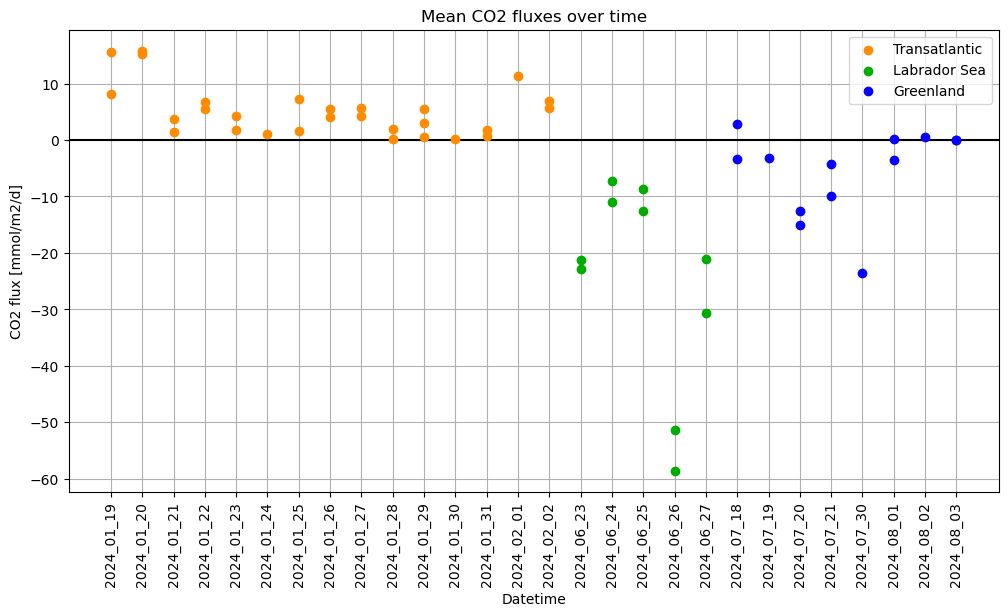

In [40]:
#CO2 fluxes

plt.figure(figsize=(12, 6))
#plt.scatter(df_CO2['Datetime'], df_CO2['Min CO2 flux [mmol/m2/d]'], marker='o', color = '#7cbcff', label='Min CO2 flux [mmol/m2/d]', zorder = 3)
#plt.scatter(df_CO2['Datetime'], df_CO2['Max CO2 flux [mmol/m2/d]'], marker='o', color = '#007cff',  label='Max CO2 flux [mmol/m2/d]', zorder = 3)
plt.scatter(df_CO2['Datetime'][:28], df_CO2['Mean CO2 flux [mmol/m2/d]'][:28], marker='o', color = '#ff8b00',  label='Transatlantic', zorder = 3)
plt.scatter(df_CO2['Datetime'][28:38], df_CO2['Mean CO2 flux [mmol/m2/d]'][28:38], marker='o', color = '#00ac00',  label='Labrador Sea', zorder = 3)
plt.scatter(df_CO2['Datetime'][38:], df_CO2['Mean CO2 flux [mmol/m2/d]'][38:], marker='o', color = '#0800ff',  label='Greenland', zorder = 3)
plt.axhline(y=0, color='#000000', linestyle='-', linewidth=1.5, zorder=2)

plt.title('Mean CO2 fluxes over time')
plt.xlabel('Datetime')
plt.ylabel('CO2 flux [mmol/m2/d]')
plt.xticks(rotation=90)
plt.grid(True, zorder=0)
plt.legend()

# Export as an image
plt.savefig(os.path.join('Results', 'CO2_flux.png' ), bbox_inches='tight', dpi=300)

plt.show()

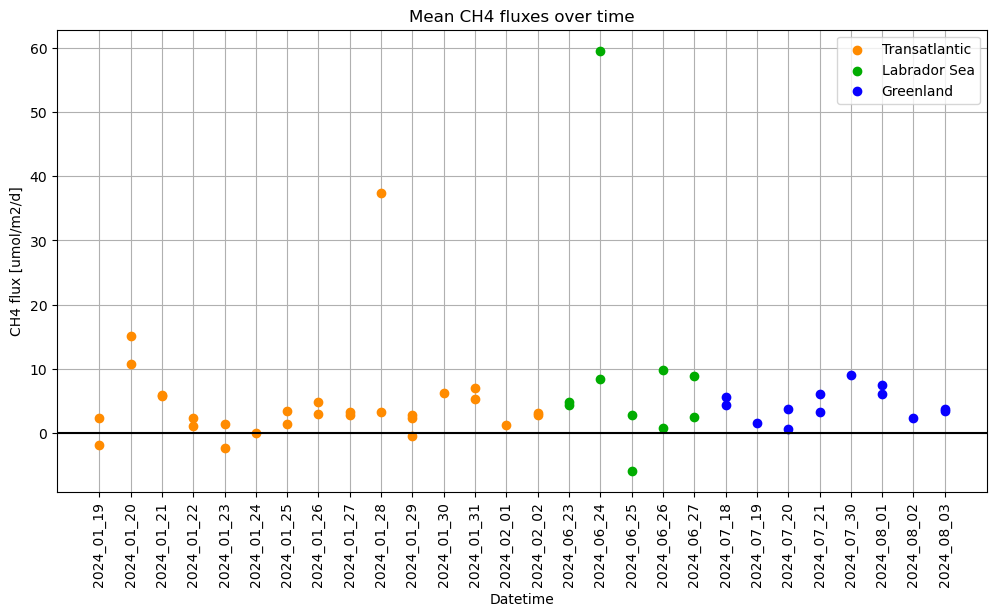

In [41]:
#CH4 fluxes

plt.figure(figsize=(12, 6))
#plt.scatter(df_CH4['Datetime'], df_CH4['Min CH4 flux [umol/m2/d]'], marker='o', color = '#7cbcff', label='Min CH4 flux [umol/m2/d]', zorder = 2)
#plt.scatter(df_CH4['Datetime'], df_CH4['Max CH4 flux [umol/m2/d]'], marker='o', color = '#007cff',  label='Max CH4 flux [umol/m2/d]', zorder = 2)
plt.scatter(df_CH4['Datetime'][:28], df_CH4['Mean CH4 flux [umol/m2/d]'][:28], marker='o', color = '#ff8b00',  label='Transatlantic', zorder = 2)
plt.scatter(df_CH4['Datetime'][28:38], df_CH4['Mean CH4 flux [umol/m2/d]'][28:38], marker='o', color = '#00ac00',  label='Labrador Sea', zorder = 2)
plt.scatter(df_CH4['Datetime'][38:], df_CH4['Mean CH4 flux [umol/m2/d]'][38:], marker='o', color = '#0800ff',  label='Greenland', zorder = 2)
plt.axhline(y=0, color='#000000', linestyle='-', linewidth=1.5, zorder=2)

plt.title('Mean CH4 fluxes over time')
plt.xlabel('Datetime')
plt.ylabel('CH4 flux [umol/m2/d]')
plt.xticks(rotation=90)
plt.grid(True, zorder=0)
plt.legend()

# Export as an image
plt.savefig(os.path.join('Results', 'CH4_flux.png' ), bbox_inches='tight', dpi=300)

plt.show()

## Map of the fluxes

In [35]:
# Compute the mean CO2/CH4 fluxes (from a duplicate perspective), ie mean mean CO2/CH4 fluxes (MM_CO2
F_MM_CO2_mmolm2d = df_CO2.groupby('Datetime')['Mean CO2 flux [mmol/m2/d]'].mean().reset_index()
F_MM_CO2_mmolm2d.rename(columns={'Mean CO2 flux [mmol/m2/d]': 'MM CO2 flux [mmol/m2/d]'}, inplace=True)
print(F_MM_CO2_mmolm2d)

F_MM_CH4_umolm2d = df_CH4.groupby('Datetime')['Mean CH4 flux [umol/m2/d]'].mean().reset_index()
F_MM_CH4_umolm2d.rename(columns={'Mean CH4 flux [umol/m2/d]': 'MM CH4 flux [umol/m2/d]'}, inplace=True)
print(F_MM_CH4_umolm2d)

# Merge the mean values back into the original DataFrame
df_CO2 = df_CO2.merge(F_MM_CO2_mmolm2d, on='Datetime', how='left')
df_CH4 = df_CH4.merge(F_MM_CH4_umolm2d, on='Datetime', how='left')
print(df_CO2.head())
print(df_CH4.head())

      Datetime  MM CO2 flux [mmol/m2/d]
0   2024_01_19                11.891953
1   2024_01_20                15.512275
2   2024_01_21                 2.560986
3   2024_01_22                 6.126190
4   2024_01_23                 2.951257
5   2024_01_24                 1.067636
6   2024_01_25                 4.479532
7   2024_01_26                 4.807366
8   2024_01_27                 4.892902
9   2024_01_28                 1.058562
10  2024_01_29                 2.985052
11  2024_01_30                 0.219311
12  2024_01_31                 1.213893
13  2024_02_01                11.286071
14  2024_02_02                 6.256442
15  2024_06_23               -22.001801
16  2024_06_24                -9.079325
17  2024_06_25               -10.664413
18  2024_06_26               -54.962635
19  2024_06_27               -25.910120
20  2024_07_18                -0.238227
21  2024_07_19                -3.117828
22  2024_07_20               -13.860831
23  2024_07_21                -7.084558


C:\Users\lolap\AppData\Local\Temp\ipykernel_37164\1478690506.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('RdBu_r')


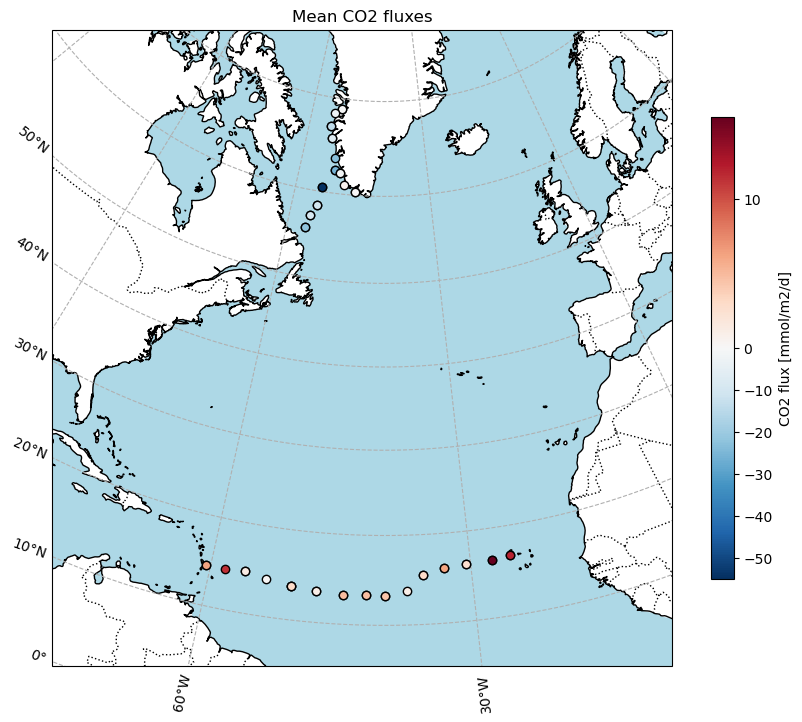

In [42]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-40, central_latitude=50)}, figsize=(10, 10))

# Set map extent (focus on North Atlantic)
ax.set_extent([-75, -10, 5, 75], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor="white")
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Normalize the concentration values for color scaling
norm = mcolors.TwoSlopeNorm(vmin=df_CO2['MM CO2 flux [mmol/m2/d]'].min(), vcenter=0, vmax=df_CO2['MM CO2 flux [mmol/m2/d]'].max())
colormap = cm.get_cmap('RdBu_r')

# Plot the GPS points with color depending on concentration
for _, row in df_CO2.iterrows():
    rgba = colormap(norm(row['MM CO2 flux [mmol/m2/d]']))  # Get the color based on concentration
    hex_color = mcolors.to_hex(rgba)  # Convert to hex color
    ax.plot(row['Long'], row['Lat'], marker='o', markeredgecolor = 'black', markersize=6, color=hex_color, transform=ccrs.PlateCarree())

# Add colorbar legend
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Needed only for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
cbar.set_label('CO2 flux [mmol/m2/d]')

# Add title
plt.title("Mean CO2 fluxes")

# Export as an image
plt.savefig(os.path.join('Results', 'Map_CO2_flux.png' ), bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

C:\Users\lolap\AppData\Local\Temp\ipykernel_37164\1276486985.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('RdBu_r')


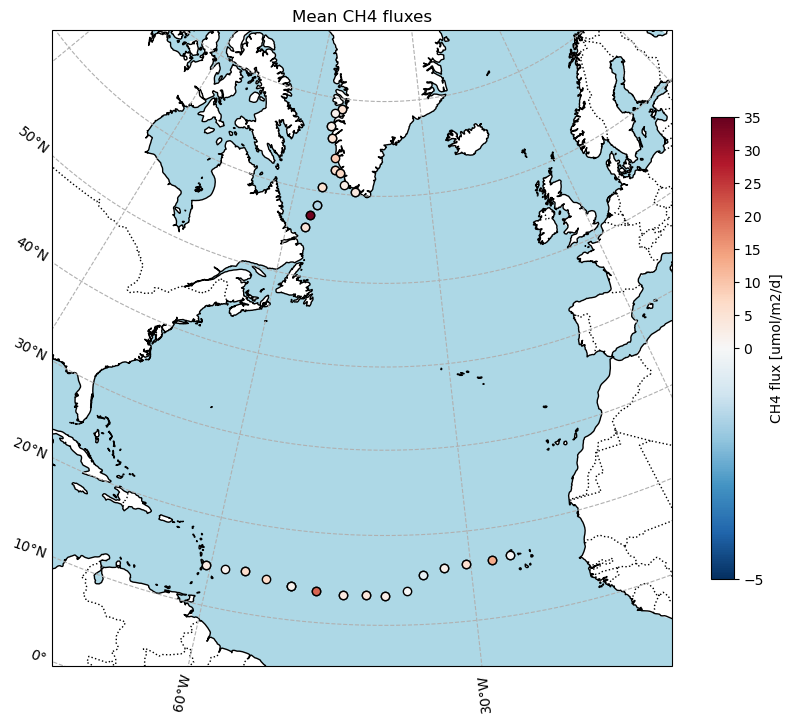

In [52]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-40, central_latitude=50)}, figsize=(10, 10))

# Set map extent (focus on North Atlantic)
ax.set_extent([-75, -10, 5, 75], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor="white")
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Normalize the concentration values for color scaling
norm = mcolors.TwoSlopeNorm(vmin=-5, vcenter = 0, vmax=35)
colormap = cm.get_cmap('RdBu_r')

# Plot the GPS points with color depending on concentration
for _, row in df_CH4.iterrows():
    rgba = colormap(norm(row['MM CH4 flux [umol/m2/d]']))  # Get the color based on concentration
    hex_color = mcolors.to_hex(rgba)  # Convert to hex color
    ax.plot(row['Long'], row['Lat'], marker='o', markeredgecolor = 'black', markersize=6, color=hex_color, transform=ccrs.PlateCarree())

# Add colorbar legend
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Needed only for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
cbar.set_label('CH4 flux [umol/m2/d]')

# Add title
plt.title("Mean CH4 fluxes")

# Export as an image
plt.savefig(os.path.join('Results', 'Map_CH4_flux.png' ), bbox_inches='tight', dpi=300)

# Show the plot
plt.show()